In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE = 128 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.005 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 50 #@param {type:"integer"}

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out, v_stride, v_dropout):
    super().__init__()
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, strides=v_stride, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.drop = tf.keras.layers.Dropout(v_dropout)

  def call(self, inputs):
    return (self.drop(tf.nn.relu(self.bn(self.conv(inputs)))))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_in, c_out):
    super().__init__()
    self.c_in = c_in
    self.c_out = c_out
    self.v_stride = 1
    self.v_dropout = .05
    self.conv_bn1 = ConvBN(self.c_out, self.v_stride, self.v_dropout)
    self.conv_bn2 = ConvBN(self.c_out, self.v_stride, self.v_dropout)
    self.adjconv = tf.keras.layers.Conv2D(filters=self.c_out, kernel_size=1,strides=self.v_stride,padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    
  def call(self, inputs):
    h = self.conv_bn2(self.conv_bn1(inputs))

    if (self.c_in != self.c_out):
      h = h + self.adjconv(inputs)
    else:
      h = h + inputs

    return h

    

In [0]:
class ResNet_V2_18(tf.keras.Model):
  def __init__(self, c=64):
    super().__init__()
    self.convbn = ConvBN(c, v_stride=1, v_dropout=0.05)
    self.blk1 = ResBlk(c, c)
    self.blk2 = ResBlk(c, c)
    self.blk3 = ResBlk(c, c*2)
    self.blk4 = ResBlk(c*2, c*2)
    self.blk5 = ResBlk(c*2, c*4)
    self.blk6 = ResBlk(c*4, c*4)
    self.blk7 = ResBlk(c*4, c*8)
    self.blk8 = ResBlk(c*8, c*8)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
  
  def call(self, x, y):
    
    h1 = self.blk4(self.blk3(self.blk2(self.blk1(self.convbn(x)))))
    h2 = self.blk8(self.blk7(self.blk6(self.blk5(h1))))
    h = self.pool(h2)
    h = self.linear(h)
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

train_mean = np.array([0.4914, 0.4822, 0.4465])
train_std = np.array([0.2023, 0.1994, 0.2010])

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [0]:
model = ResNet_V2_18()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

In [0]:

t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
prevBestAcc = 0.0

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
  
  modelPathName = '/content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5'

  currentTestAcc = (test_acc/len_test)
  
  if(currentTestAcc > prevBestAcc):
    print('Accuracy improved from {} to {}. Saving model {}'.format(prevBestAcc,currentTestAcc,modelPathName))
    prevBestAcc = currentTestAcc
    model.save_weights(modelPathName)

  if(currentTestAcc >= 0.92):
    print('Accuracy of >= 92% achieved. Exiting model training.') 
    model.save_weights(modelPathName)
    break 
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


Accuracy improved from 0.0 to 0.4286. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 1 lr: 0.0005 train loss: 1.9538962658691406 train acc: 0.3079 val loss: 1.5613336357116698 val acc: 0.4286 time: 287.8622987270355



Accuracy improved from 0.4286 to 0.5394. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 2 lr: 0.001 train loss: 1.3926338745117188 train acc: 0.5062 val loss: 1.2759750415802003 val acc: 0.5394 time: 570.5497052669525



Accuracy improved from 0.5394 to 0.6769. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 3 lr: 0.0015 train loss: 1.2037306489562989 train acc: 0.5866 val loss: 0.9124206424713135 val acc: 0.6769 time: 852.8850054740906



epoch: 4 lr: 0.002 train loss: 1.0304286093139647 train acc: 0.64792 val loss: 0.9711243317604065 val acc: 0.6602 time: 1134.6548869609833



epoch: 5 lr: 0.0025 train loss: 0.8690771113586426 train acc: 0.70066 val loss: 0.9940183403015137 val acc: 0.6651 time: 1416.2531039714813



Accuracy improved from 0.6769 to 0.7491. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 6 lr: 0.003 train loss: 0.739953018951416 train acc: 0.74478 val loss: 0.7386290702342987 val acc: 0.7491 time: 1698.7202484607697



Accuracy improved from 0.7491 to 0.7769. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 7 lr: 0.0035 train loss: 0.638834591140747 train acc: 0.7784 val loss: 0.6504393690109253 val acc: 0.7769 time: 1981.3003475666046



Accuracy improved from 0.7769 to 0.7957. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 8 lr: 0.004 train loss: 0.5687230886840821 train acc: 0.8047 val loss: 0.606234450340271 val acc: 0.7957 time: 2263.8111593723297



epoch: 9 lr: 0.0045000000000000005 train loss: 0.5173818288421631 train acc: 0.82348 val loss: 0.6473902100563049 val acc: 0.7818 time: 2546.4075756073



Accuracy improved from 0.7957 to 0.843. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 10 lr: 0.005 train loss: 0.4818194771194458 train acc: 0.8355 val loss: 0.46918705992698667 val acc: 0.843 time: 2829.614255428314



epoch: 11 lr: 0.004875 train loss: 0.4326833113861084 train acc: 0.8498 val loss: 0.5187272745132446 val acc: 0.8271 time: 3111.5954751968384



Accuracy improved from 0.843 to 0.8519. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 12 lr: 0.00475 train loss: 0.38794524909973144 train acc: 0.867 val loss: 0.44626378128528593 val acc: 0.8519 time: 3394.9145843982697



epoch: 13 lr: 0.004625 train loss: 0.35113188903808595 train acc: 0.8778 val loss: 0.4788691270828247 val acc: 0.8412 time: 3677.427724838257



Accuracy improved from 0.8519 to 0.866. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 14 lr: 0.0045000000000000005 train loss: 0.3185239154052734 train acc: 0.88918 val loss: 0.4154366494178772 val acc: 0.866 time: 3960.5027294158936



epoch: 15 lr: 0.004375 train loss: 0.2886629261398315 train acc: 0.90022 val loss: 0.4190750921487808 val acc: 0.8612 time: 4242.515877246857



Accuracy improved from 0.866 to 0.8714. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 16 lr: 0.00425 train loss: 0.2577678981018066 train acc: 0.91098 val loss: 0.3920783024787903 val acc: 0.8714 time: 4526.812137842178



Accuracy improved from 0.8714 to 0.8845. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 17 lr: 0.004125 train loss: 0.2389735548019409 train acc: 0.91588 val loss: 0.3480534369945526 val acc: 0.8845 time: 4809.003137111664



epoch: 18 lr: 0.004 train loss: 0.21427207859039307 train acc: 0.92602 val loss: 0.38957421073913573 val acc: 0.8747 time: 5090.7267899513245



Accuracy improved from 0.8845 to 0.8905. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 19 lr: 0.003875 train loss: 0.1947158723831177 train acc: 0.93202 val loss: 0.3382129568099976 val acc: 0.8905 time: 5373.213204860687



Accuracy improved from 0.8905 to 0.8965. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 20 lr: 0.00375 train loss: 0.18056161836624146 train acc: 0.9355 val loss: 0.3407283163309097 val acc: 0.8965 time: 5655.818401813507



epoch: 21 lr: 0.003625 train loss: 0.16691696826934815 train acc: 0.94238 val loss: 0.3604794858932495 val acc: 0.8851 time: 5937.421915531158



Accuracy improved from 0.8965 to 0.8984. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 22 lr: 0.0035 train loss: 0.1477285363817215 train acc: 0.94908 val loss: 0.3305599449157715 val acc: 0.8984 time: 6219.529793739319



epoch: 23 lr: 0.003375 train loss: 0.12903429423332213 train acc: 0.95466 val loss: 0.33666832160949706 val acc: 0.8937 time: 6501.564888715744



epoch: 24 lr: 0.0032500000000000003 train loss: 0.11772107211112975 train acc: 0.95916 val loss: 0.3445636224269867 val acc: 0.8947 time: 6783.250037193298



Accuracy improved from 0.8984 to 0.901. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 25 lr: 0.003125 train loss: 0.10497255465507507 train acc: 0.96356 val loss: 0.3284751646280289 val acc: 0.901 time: 7066.049056529999



Accuracy improved from 0.901 to 0.908. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 26 lr: 0.003 train loss: 0.09771855795383454 train acc: 0.9667 val loss: 0.30966601078510286 val acc: 0.908 time: 7348.704168319702



epoch: 27 lr: 0.002875 train loss: 0.0887586225605011 train acc: 0.96952 val loss: 0.33150196022987366 val acc: 0.9011 time: 7630.824005842209



epoch: 28 lr: 0.00275 train loss: 0.07693001785755157 train acc: 0.97426 val loss: 0.3126135798871517 val acc: 0.907 time: 7912.50315785408



Accuracy improved from 0.908 to 0.9094. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 29 lr: 0.002625 train loss: 0.06866957334518432 train acc: 0.9775 val loss: 0.3134406527131796 val acc: 0.9094 time: 8195.324298858643



epoch: 30 lr: 0.0025 train loss: 0.0590394983625412 train acc: 0.9809 val loss: 0.31074529977440835 val acc: 0.9093 time: 8477.877086639404



Accuracy improved from 0.9094 to 0.9101. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 31 lr: 0.002375 train loss: 0.054826425006389616 train acc: 0.98222 val loss: 0.31408218845129016 val acc: 0.9101 time: 8761.31915807724



epoch: 32 lr: 0.0022500000000000003 train loss: 0.045133747100830075 train acc: 0.98582 val loss: 0.33210771091580393 val acc: 0.9082 time: 9043.512507915497



Accuracy improved from 0.9101 to 0.9147. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 33 lr: 0.002125 train loss: 0.042042122852802274 train acc: 0.9873 val loss: 0.312469590139389 val acc: 0.9147 time: 9326.057570457458



Accuracy improved from 0.9147 to 0.916. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 34 lr: 0.002 train loss: 0.03579313212275505 train acc: 0.98908 val loss: 0.3078902906537056 val acc: 0.916 time: 9608.838955879211



epoch: 35 lr: 0.001875 train loss: 0.03482812991023063 train acc: 0.98918 val loss: 0.316831003934145 val acc: 0.9119 time: 9890.911710977554



Accuracy improved from 0.916 to 0.9175. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 36 lr: 0.0017499999999999998 train loss: 0.029844116567373277 train acc: 0.99136 val loss: 0.30475433673858643 val acc: 0.9175 time: 10173.437883853912



epoch: 37 lr: 0.0016250000000000001 train loss: 0.02623489425420761 train acc: 0.99216 val loss: 0.32097716044187546 val acc: 0.9142 time: 10455.574868917465



epoch: 38 lr: 0.0015 train loss: 0.02453729880452156 train acc: 0.99306 val loss: 0.31527374512553213 val acc: 0.9173 time: 10737.547116994858



epoch: 39 lr: 0.001375 train loss: 0.02074955178618431 train acc: 0.99428 val loss: 0.304852077293396 val acc: 0.9169 time: 11020.758245706558



Accuracy improved from 0.9175 to 0.9199. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
epoch: 40 lr: 0.0012500000000000002 train loss: 0.017901839273571966 train acc: 0.99568 val loss: 0.30073238266706465 val acc: 0.9199 time: 11304.920711040497



Accuracy improved from 0.9199 to 0.9208. Saving model /content/drive/My Drive/EVA_Model/Assignment13_BestModelWeights.h5
Accuracy of >= 92% achieved. Exiting model training.


Using TensorFlow backend.


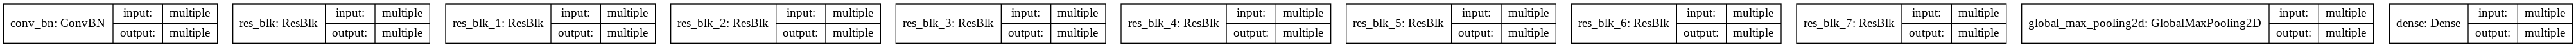

In [0]:
#model.summary()

from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)